In [1]:
!git clone https://github.com/lukemelas/EfficientNet-PyTorch
!cd EfficientNet-PyTorch && pip install -e .

Cloning into 'EfficientNet-PyTorch'...
remote: Enumerating objects: 665, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 665 (delta 26), reused 58 (delta 23), pack-reused 595 (from 1)
Receiving objects: 100% (665/665), 1.14 MiB | 6.80 MiB/s, done.
Resolving deltas: 100% (341/341), done.
Obtaining file:///content/EfficientNet-PyTorch
  Preparing metadata (setup.py) ... done
  Running setup.py develop for efficientnet_pytorch


In [2]:
pip show efficientnet-pytorch


Name: efficientnet_pytorch
Version: 0.7.1
Summary: EfficientNet implemented in PyTorch.
Home-page: https://github.com/lukemelas/EfficientNet-PyTorch
Author: Luke
Author-email: lmelaskyriazi@college.harvard.edu
License: Apache
Location: /content/EfficientNet-PyTorch
Editable project location: /content/EfficientNet-PyTorch
Requires: torch
Required-by: 


In [1]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os

# 지정한 경로의 파일 및 폴더 목록 가져오기
files = os.listdir('/content/drive/MyDrive/딥러닝/project/팀플폴더')  # 디렉토리 경로를 지정하세요.
print(files)

['test', 'train', '우리가 직접 모은 패널 사진']


In [3]:
import cv2
import numpy as np

target_size = (224,224)

def load_dataset(groups_folder_path, categories):

    Y = []
    X = []

    for idx, category in enumerate(categories):
        label = idx  # 정수 레이블로 변경
        image_dir = os.path.join(groups_folder_path, category)

        file_list = os.listdir(image_dir)

        for filename in file_list:
            if filename.lower().endswith('.jpg'):
                url = os.path.join(image_dir, filename)
                img = cv2.imread(url)
                if img is not None:  # 이미지를 성공적으로 읽었는지 확인
                     img_resized = cv2.resize(img, target_size)
                     X.append(img_resized)
                     Y.append(label)

    return X, Y

test_folder_path = os.path.join('/content/drive/MyDrive/딥러닝/project/팀플폴더', '우리가 직접 모은 패널 사진')

categories = ['Physical-Damage', 'Electrical-damage', 'Snow-Covered', 'Dusty', 'Bird-drop', 'Clean']

X_test, Y_test = load_dataset(test_folder_path, categories)



In [4]:

X_test = np.array(X_test)
Y_test = np.array(Y_test)

print(f"test 이미지 데이터 shape: {X_test.shape}")
print(f"test 레이블 데이터 shape: {Y_test.shape}")

print(np.unique(Y_test, return_counts=True))

test 이미지 데이터 shape: (60, 224, 224, 3)
test 레이블 데이터 shape: (60,)
(array([0, 1, 2, 3, 4, 5]), array([10, 10, 10, 10, 10, 10]))


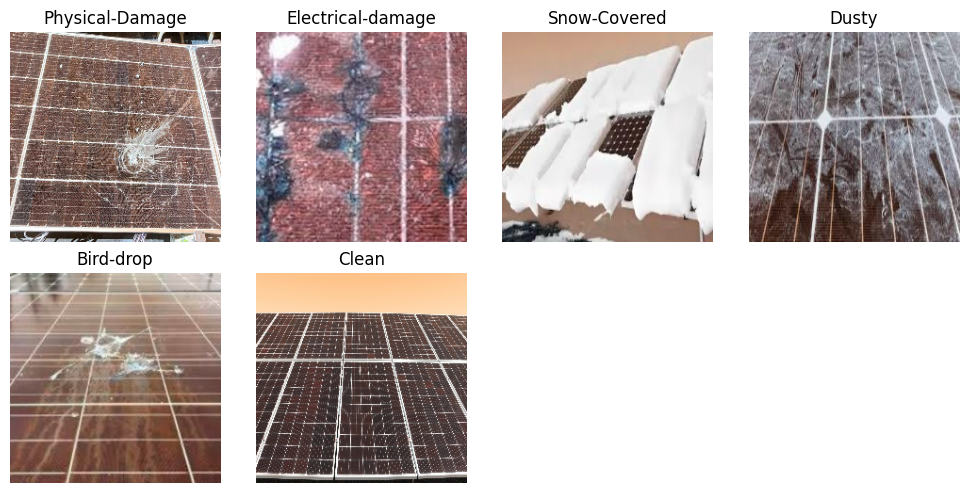

In [5]:
import matplotlib.pyplot as plt

# 클래스별로 이미지 하나씩 시각화
num_classes = len(categories)

# 각 클래스의 첫 번째 이미지 인덱스 찾기
class_first_indices = [np.where(Y_test == i)[0][0] for i in range(num_classes)]

# 이미지 출력 설정
plt.figure(figsize=(10, 5))
for i, idx in enumerate(class_first_indices):
    plt.subplot(2, 4, i + 1)  # 2행 5열의 subplot을 만들고 각 클래스별 이미지 출력
    plt.imshow(X_test[idx])
    plt.title(categories[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

# For normalization, ImageNet 데이터셋에 사용된 평균과 표준편차 사용
in_mean = (0.485, 0.456, 0.406)
in_std = (0.229, 0.224, 0.225)

# 검증 및 테스트 데이터셋에는 증강 적용 안 함
test_transform = transforms.Compose([
    transforms.ToTensor(),  #  0 ~ 1 범위로 변환
    transforms.Normalize(in_mean, in_std)  # 사전에 정의한 평균과 표준편차를 사용하여 정규화
])

class CustomDataset(Dataset):
    def __init__(self, X, y, mode='train'):  # mode 인자 추가
        self.X = X
        self.y = torch.tensor(y, dtype=torch.long)
        self.mode = mode  # mode 저장

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.mode == 'train':
            x = train_transform(x)
        else:  # 'valid' 또는 'test'
            x = test_transform(x)
        y = self.y[idx]
        return x, y

# 테스트 데이터셋 생성
test_dataset = CustomDataset(X_test, Y_test, mode='test')

# DataLoader 생성
dataloaders, batch_num = {}, {}
batch_size = 1

dataloaders['test'] = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)

batch_num['test'] = len(dataloaders['test'])


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from efficientnet_pytorch import EfficientNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 클래스 이름 가져오기
class_names = ['Physical-Damage', 'Electrical-damage', 'Snow-Covered', 'Dusty', 'Bird-drop', 'Clean']

# 클래스별 샘플 저장용 딕셔너리 초기화
class_samples = {label: [] for label in range(len(class_names))}

# 각 클래스별 최대 4개 샘플 선택
for images, labels in dataloaders['test']:  # use dataloader to iterate over batches
    for i in range(len(labels)):
        label = labels[i].item()  # Get the label for the current image
        if len(class_samples[label]) < 6:  # Add up to 4 images per class
            class_samples[label].append(images[i])
        if all(len(samples) == 6 for samples in class_samples.values()):  # Stop once we've selected 4 images for each class
            break
    if all(len(samples) == 6 for samples in class_samples.values()):
        break
# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)


# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/딥러닝/project/adam 모델/잘나온거/adam_64_lr1_0.0002.pt', map_location=torch.device('cpu')))

# 모델을 평가 모드로 설정
model.eval()

# 시각화: 각 클래스당 4개 샘플 출력
plt.figure(figsize=(20, 20))
plot_idx = 1

for label, images in class_samples.items():
    for img in images:
        ax = plt.subplot(len(class_names), 6, plot_idx)

        # 이미지를 NumPy 배열로 변환
        img_np = img.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img_np = np.clip(img_np * in_std + in_mean, 0, 1)  # Reverse normalization for visualization

        plt.imshow(img_np)

        # 모델 예측 수행
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to the same device as the model
        with torch.no_grad():  # Disable gradient calculation
            outputs = model(img)
            _, preds = torch.max(outputs, 1)  # Get the predicted class

        # 예측 클래스와 실제 클래스
        predicted_class_label = class_names[preds.item()]
        actual_class_label = class_names[label]

        # 정확도 및 라벨 색상 설정
        if actual_class_label == predicted_class_label:
            color = 'green'
            accuracy_text = f"Correct ({actual_class_label})"
        else:
            color = 'red'
            accuracy_text = f"Incorrect (Actual: {actual_class_label}, Predicted: {predicted_class_label})"

        # 예측 확률 계산 및 출력
        score = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities for each class
        predicted_prob = round(score[0, preds].item() * 100, 2)  # Probability of predicted class

        # 타이틀 추가
        plt.title(f"{accuracy_text}\nProb: {predicted_prob}%", color=color, fontsize=10)
        plt.axis("off")
        plot_idx += 1

plt.tight_layout()  # Adjust subplot spacing
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)


# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/딥러닝/project/adam 모델/잘나온거/adam_64_lr1_0.0002.pt', map_location=torch.device('cpu')))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도와 손실을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100

    return epoch_loss, epoch_acc

# test 데이터셋에 대해 평가
test_loss, test_acc = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')


Loaded pretrained weights for efficientnet-b0


<ipython-input-12-8f626fd83de9>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/딥러닝/project/adam 모델/잘나ᄋ

Test Loss: 0.5781
Test Accuracy: 81.67%


In [9]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
import time  # time 모듈을 임포트

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/딥러닝/project/adam 모델/잘나온거/adam_64_lr1_0.0002.pt', map_location=torch.device('cpu')))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도, 손실, 그리고 inference time을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0
    total_inference_time = 0.0  # 전체 inference time을 저장할 변수

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass 시간 측정 시작
            start_time = time.time()  # 현재 시간을 기록

            # 모델 예측 수행
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # Forward pass 시간 측정 종료
            end_time = time.time()
            inference_time = end_time - start_time  # 예측에 소요된 시간 계산

            # 전체 inference time 누적
            total_inference_time += inference_time

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100
    average_inference_time = total_inference_time / len(dataloader)  # 배치당 평균 inference time

    return epoch_loss, epoch_acc, average_inference_time

# test 데이터셋에 대해 평가
test_loss, test_acc, avg_inference_time = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')
print(f'inference time: {avg_inference_time:.6f} seconds')



Loaded pretrained weights for efficientnet-b0


<ipython-input-9-88c6d0f436fe>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/딥러닝/project/adam 모델/잘나오

Test Loss: 0.5781
Test Accuracy: 81.67%
inference time: 0.092148 seconds
